Logs 
- [2025/02/28]   
  First version of the application of genetic algorithm to two-dimensional
  optimization problem with Ackley's function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as plt_cm

import plotly.graph_objects as go   # pip install plotly nbformat (and restart kernel)

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

### Problem statement

$$
  \argmin_{(x_1, x_2) \in [-5, 5]^2} 
    f(x_1) = -20 \exp \left( -0.2 \sqrt{\frac{x_1^2 + x_2^2}{2}}\right)
      -\exp\left( \frac{\cos(2\pi x_1) + \cos(2\pi x_2)}{2}\right) 
      + 20 + \exp(1)
$$

In [3]:
def obj_func(x1, x2, a=20, b=0.2, c=2.*np.pi):
  term1 = -a*np.exp(-b*np.sqrt((x1**2 + x2**2)/2.))
  term2 = -np.exp((np.cos(c*x1) + np.cos(c*x2))/2.)
  return term1 + term2 + a + np.exp(1) 

The plot of function $f(x_1)`$

In [4]:
%matplotlib inline
N_x1 = 100
N_x2 = 100
x1_range = [-5., 5.]
x2_range = [-5., 5.]
x1_space = np.linspace(x1_range[0], x1_range[1], N_x1)
x2_space = np.linspace(x2_range[0], x2_range[1], N_x2)
x1_mesh, x2_mesh = np.meshgrid(x1_space, x2_space)

f_vals = obj_func(x1_mesh, x2_mesh)

fig = go.Figure(data=[go.Surface(z=f_vals, x=x1_space, y=x2_space, 
                                  colorscale="Inferno", opacity=1)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

r = 1.5
camera = {"eye": {"x": r, "y": r, "z": r}}
fig.update_layout(autosize=False, width=500, height=400, 
                  scene={"xaxis_title": "<i>x</i>",
                         "yaxis_title": "<i>y</i>",
                         "zaxis_title": "<i>f(x, y)</i>",
                         "aspectratio": {"x": 1, "y": 1, "z": 0.8}},
                  margin={"l":5, "r":10, "b":5, "t":10},
                  scene_camera=camera,
                  legend={"x": 0.1, "y": 0.9})

fig.show()

### Reproduction

In [5]:
def reproduction(x_ga, rng=None):
  # -- calculate fitness 
  fitness_vals = np.array([obj_func(x_ga_i[0], x_ga_i[1]) for x_ga_i in x_ga])
  
  epsilon = 1e-4   
  fitness_vals += epsilon           # to avoid division by zero
  fitness_vals = 1./fitness_vals    # because we want to achieve minimization 
  
  # -- sort the fitness_vals
  idx_sorted = np.argsort(fitness_vals)
  sorted_fitness_vals = fitness_vals[idx_sorted].copy()
  sorted_x_ga = x_ga[idx_sorted].copy()
  # print(sorted_fitness_vals)

  # -- perform roulette wheel selection
  normalized_fitness_vals = sorted_fitness_vals/np.sum(sorted_fitness_vals)
  normalized_fitness_vals = np.cumsum(normalized_fitness_vals)
  # print(normalized_fitness_vals)
  
  new_x_ga = np.zeros_like(x_ga)
  for i in range(N_sample):
    r = rng.random()
    idx = np.where(normalized_fitness_vals > r)[0][0]
    new_x_ga[i] = sorted_x_ga[idx].copy()
  # print(new_x_ga)

  return new_x_ga

### Crossover

In [6]:
def crossover(x_ga, crossover_rate, rng=None):
  new_x_ga = np.zeros_like(x_ga)

  num_of_crossover = int(crossover_rate * len(x_ga))
  for i in range(num_of_crossover):
    idx = rng.integers(0, len(x_ga))
    x_ga1 = x_ga[idx].copy()
    idx = rng.integers(0, len(x_ga))
    x_ga2 = x_ga[idx].copy()

    # here we define crossover to be the midpoint of two given points
    # in general you can define any crossover method according to the
    # problem you are solving
    new_x_ga[i] = 0.5*(x_ga1 + x_ga2)

  for i in range(num_of_crossover, len(x_ga)):
    new_x_ga[i] = x_ga[i].copy()

  return new_x_ga

### Mutation

In [7]:
def mutation(x_ga, mutation_rate, rng=None):
  r = rng.random()
  
  new_x_ga = np.zeros_like(x_ga)
  for i in range(len(x_ga)):
    if r < mutation_rate:
      # new_x_ga[i] = x_ga[i] + rng.normal(x_ga[i])
      new_x_ga[i] = x_ga[i] + rng.normal(x_ga[i], [0.1, 0.1])   # set a lower standard deviation
    else:
      new_x_ga[i] = x_ga[i].copy()
  
  return new_x_ga

### Running genetic algorithm

In [12]:
hist_x_ga

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [54]:
seed = 25_02_26   # the underscore does not change the value, it is still an integer
rng = np.random.default_rng(seed)

N_sample = 20   # number of samples should be even
dim = 2
x1_range = [-5., 5.]
x2_range = [-5., 5.]
x_ga = rng.uniform(low=[x1_range[0], x2_range[0]],
                    high=[x1_range[1], x2_range[1]], size=(N_sample,dim))
print(x_ga)

G_max = 100
crossovoer_rate = 0.9
mutation_rate = 0.1
sf_max = 0.001      # standard deviation for fitness values hist_x_ga = np.zeros((1, N_sample, dim))
hist_x_ga = np.zeros((1, N_sample, dim))
hist_x_ga[0] = x_ga.copy()
hist_fitness_vals = np.zeros((1, N_sample))
hist_fitness_vals[0] = obj_func(x_ga[0][0], x_ga[0][1])

is_converged = False
for G in range(G_max):
  # -- sampling mating pool (reproduction = fitness and roulette wheel selection)
  new_x_ga = reproduction(x_ga, rng=rng)

  # -- crossover
  new_x_ga = crossover(new_x_ga, crossovoer_rate, rng=rng) 

  # -- mutation
  new_x_ga = mutation(new_x_ga, mutation_rate, rng=rng)
  print(new_x_ga)

  # -- test convergence
  fitness_vals = np.array([obj_func(x_ga_i[0], x_ga_i[1]) for x_ga_i in x_ga])
  # print(fitness_vals)
  sf_fitness = np.std(fitness_vals) 


  if sf_fitness < sf_max:
    print(f"Converged at generation {G}")
    is_converged = True
    break
  else:
    hist_x_ga = np.append(hist_x_ga, [new_x_ga], axis=0)
    hist_fitness_vals = np.append(hist_fitness_vals, 
      [[obj_func(x_ga_i[0], x_ga_i[1]) for x_ga_i in new_x_ga]], axis=0)
    x_ga = new_x_ga.copy()

if not is_converged:
  print(f"Solution is not convergent")

[[ 2.96277318 -1.74187609]
 [-2.9562276  -0.66168943]
 [-1.72168124 -1.29218562]
 [-0.6844287  -2.83919811]
 [ 0.18768364 -1.68786227]
 [ 3.39680165 -1.23920442]
 [-4.78728486  1.22007329]
 [-1.94072068  0.62669931]
 [ 1.40963046 -4.68932809]
 [-1.16064302 -0.26095273]
 [ 1.95470654 -3.01791766]
 [ 4.88753346 -1.58412639]
 [-4.16629463  4.74520896]
 [ 4.11383507  4.59337226]
 [ 2.38198953  2.85147677]
 [-0.14223223  0.84156061]
 [ 2.19147926 -1.27456844]
 [-0.34195426 -2.36843413]
 [ 4.84609773 -0.6860634 ]
 [ 3.55093905 -0.39359257]]
[[ 2.47028103 -3.03376755]
 [ 3.09451397 -3.37195474]
 [ 5.08131669 -3.04281599]
 [ 6.74983161 -2.34347729]
 [ 1.25835802 -1.49690601]
 [ 2.04064864 -4.70035181]
 [ 1.02522478 -1.65338984]
 [-2.66924386 -0.08549497]
 [ 1.17197022  2.46465127]
 [-2.79501662  0.14246052]
 [-2.058473   -3.19758512]
 [-3.93083971  1.38092744]
 [ 5.16078833 -3.01481285]
 [-2.72988681 -0.17208098]
 [ 1.30453993 -3.19594044]
 [-1.76323793 -3.20940015]
 [ 1.3965854   2.61779008]


The history of fitness values

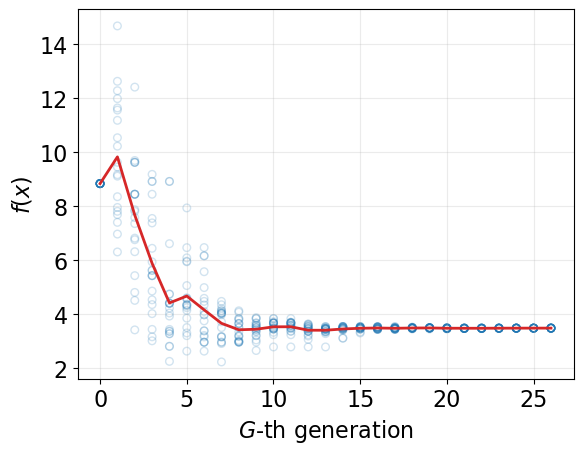

In [55]:
fig, ax = plt.subplots()

mean_fitness_over_population = []
for idx_hist in range(len(hist_x_ga)):
  x_ga_i = hist_x_ga[idx_hist]
  fitness_vals = hist_fitness_vals[idx_hist]
  N_sample = len(x_ga_i)
  ax.scatter(np.ones(N_sample)*idx_hist, hist_fitness_vals[idx_hist],
              color="tab:blue", facecolor="None", s=30, alpha=0.2)
  mean_fitness = np.mean(fitness_vals)
  mean_fitness_over_population = np.append(mean_fitness_over_population, 
    [mean_fitness])

ax.plot(mean_fitness_over_population, color="tab:red", lw=2)

ax.set_xlabel("$G$-th generation")
ax.set_ylabel("$f(x)$")
ax.grid("on")

plt.show(fig)

In [56]:
hist_x_ga.shape

(27, 20, 2)

In [57]:
hist_x_ga

array([[[ 2.96277318, -1.74187609],
        [-2.9562276 , -0.66168943],
        [-1.72168124, -1.29218562],
        ...,
        [-0.34195426, -2.36843413],
        [ 4.84609773, -0.6860634 ],
        [ 3.55093905, -0.39359257]],

       [[ 2.47028103, -3.03376755],
        [ 3.09451397, -3.37195474],
        [ 5.08131669, -3.04281599],
        ...,
        [ 2.29186985, -4.42805138],
        [ 4.44501251, -2.66156711],
        [-2.1796826 , -0.55505221]],

       [[ 1.21516412,  0.48387263],
        [-2.24656237, -1.69074056],
        [-0.21900848, -2.30006618],
        ...,
        [-1.76323793, -3.20940015],
        [-1.76323793, -3.20940015],
        [-1.76323793, -3.20940015]],

       ...,

       [[ 0.17108595, -0.77441586],
        [ 0.17104987, -0.77459633],
        [ 0.17082263, -0.77542905],
        ...,
        [ 0.1713008 , -0.77369768],
        [ 0.17125475, -0.77381249],
        [ 0.17091714, -0.77501923]],

       [[ 0.17106172, -0.77456336],
        [ 0.17120353, -0.77

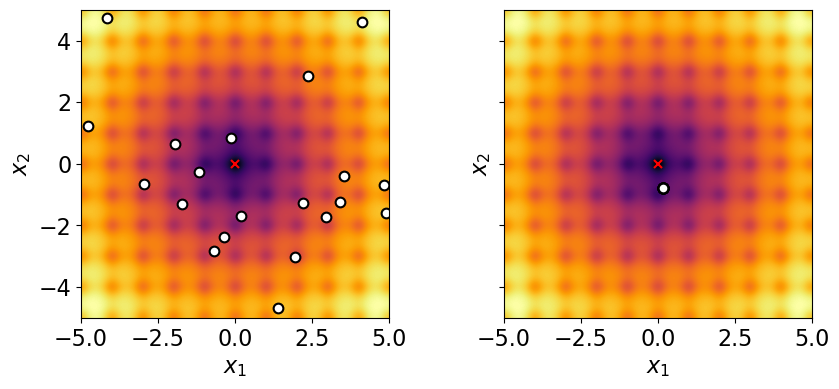

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

# -- left plot
Nx = 1000
x1_range = [-5., 5.]
x2_range = [-5., 5.]

x1_space = np.linspace(x1_range[0], x1_range[1], Nx)
x2_space = np.linspace(x2_range[0], x2_range[1], Nx)
x1_mesh, x2_mesh = np.meshgrid(x1_space, x2_space)
f_vals = obj_func(x1_mesh, x2_mesh)

axes[0].imshow(f_vals, extent=[*x1_range, *x2_range], origin="lower", cmap="inferno") 
axes[0].plot(*[0, 0], linestyle="none", marker="x", markeredgecolor="r", markeredgewidth=1.5)
skip_points = 1
axes[0].plot(hist_x_ga[0, 0::skip_points, 0],
              hist_x_ga[0, 0::skip_points, 1], linestyle="None", marker="o", 
              markerfacecolor="w", markeredgecolor="k", markeredgewidth=1.5,
              markersize=7)
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
axes[0].set_xlim([-5, 5])
axes[0].set_ylim([-5, 5])

axes[1].imshow(f_vals, extent=[*x1_range, *x2_range], origin="lower", cmap="inferno") 
axes[1].plot([0], [0], linestyle="none", marker="x", markeredgecolor="r", markeredgewidth=1.5)
skip_points = 1
# axes[1].plot(hist_x_ga[-1, 0::skip_points, 0],
#               hist_x_ga[-1, 0::skip_points, 1], linestyle="None", marker="o")
axes[1].plot(hist_x_ga[-1, 0::skip_points, 0],
              hist_x_ga[-1, 0::skip_points, 1], linestyle="None", marker="o", 
              markerfacecolor="w", markeredgecolor="k", markeredgewidth=1.5,
              markersize=7)
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_2$")
axes[1].set_xlim([-5, 5])
axes[1].set_ylim([-5, 5])

plt.show(fig)